In [380]:
import sys,os
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vaex
import astropy.units as u
from math import ceil
import reverse_indices_2d as ri
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline as spline
import cmasher as cm

%matplotlib inline

In [389]:
run ../scripts/rc_params.py

rcParams updated :)


<Figure size 504x504 with 0 Axes>

In [3]:
#Create a dataframe of PHATTER sources
#First cut to the data is GST criteria for the IR filters

phatter = vaex.open('/Users/tatianasandford/Documents/Research/M33/M33_full_matched.hdf5')
phatter.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15) & '
          '(F110W_CROWD < 2.25) & '
          '(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15) & '
          '(F160W_CROWD < 2.25)', name='IR_GST')

In [4]:
#Add index to PHATTER dataframe
phatter['INDEX'] = np.arange(len(phatter))
###Add 110-160 color column to dataframe for convenience
phatter['F110W_F160W'] = phatter['F110W_VEGA'] - phatter['F160W_VEGA']

In [5]:
# Set the aspect ratio for any ra/dec plot of M33

ra_max, ra_min = phatter.RA.max(selection='IR_GST'), phatter.RA.min(selection='IR_GST')
dec_max, dec_min = phatter.DEC.max(selection='IR_GST'), phatter.DEC.min(selection='IR_GST')
dec_m33 = phatter.DEC.mean()

m33_ar = (dec_max - dec_min) / ((ra_max - ra_min)*np.cos(np.pi/180.*dec_m33))

In [6]:
#Extract index RA and DEC  with GST cuts for easy plotting later
index_gst = phatter.INDEX.evaluate(selection='IR_GST')
ra_gst, dec_gst = phatter.RA.evaluate(selection='IR_GST'), phatter.DEC.evaluate(selection='IR_GST')

In [7]:
print('Coordinate Span of PHATTER footprint')
print('RA (deg): {:.4f} - {:.4f}'.format(ra_min, ra_max))
print('DEC (deg): {:.4f} - {:.4f}'.format(dec_min, dec_max))

Coordinate Span of PHATTER footprint
RA (deg): 23.3422 - 23.6613
DEC (deg): 30.4894 - 30.8491


In [8]:
#Create a table of unWISE sources within the PHATTER footprint

Irsa.ROW_LIMIT = 100000
wise = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=23.341,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.662,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.662,dec=30.85,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.341,dec=30.85,unit=(u.deg,u.deg),frame='icrs')])

wise[:2]

unwise_objid,ra,dec,clon,clat,x_1,dx_1,x_2,dx_2,y_1,dy_1,y_2,dy_2,flux_1,dflux_1,flux_2,dflux_2,fluxlbs_1,dfluxlbs_1,fluxlbs_2,dfluxlbs_2,qf_1,qf_2,rchi2_1,rchi2_2,fracflux_1,fracflux_2,spread_model_1,dspread_model_1,spread_model_2,dspread_model_2,fwhm_1,fwhm_2,sky_1,sky_2,nm_1,nm_2,primary_1,primary_2,primary,flags_unwise_1,flags_unwise_2,flags_info_1,flags_info_2,coadd_id,unwise_detid_1,unwise_detid_2
,deg,deg,,,pix,pix,pix,pix,pix,pix,pix,pix,'nMgy','nMgy','nMgy','nMgy','nMgy','nMgy','nMgy','nMgy',,,,,,,,,,,pix,pix,'nMgy','nMgy',,,,,,,,,,,,
object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,object,object,object
0243p302o0017123,23.62794233,30.48854987,01h34m30.71s,30d29m18.78s,1287.4643,0.02724,1287.4427,0.11599,1835.6880,0.02823,1835.9147,0.11412,539.8800,8.8048,477.9500,29.6750,512.8600,8.9965,446.1800,30.4630,1.000,1.000,15.084,1.254,0.88,0.90,0.008,0.0006,0.010,0.0024,2.624,2.846,13.5,8.9,127,127,1,1,1,0,0,66,66,0243p302,0243p302w1o0027393,0243p302w2o0016553
0243p302o0017136,23.63701125,30.48934148,01h34m32.88s,30d29m21.63s,1288.4358,0.01091,1288.4726,0.04059,1825.4499,0.01131,1825.3690,0.03993,1448.6000,10.2680,1405.2000,31.5860,1409.2000,10.4690,1382.7000,32.3850,1.000,1.000,9.264,0.502,0.99,0.99,0.001,0.0003,0.000,0.0009,2.625,2.850,11.8,7.7,124,126,1,1,1,0,0,66,66,0243p302,0243p302w1o0027419,0243p302w2o0016565


In [9]:
#Cut any unWISE source with the flag 'primary' not equal to 1
#This will elminate duplicate sources
dup_cut, = np.where(wise['primary'] == 1)

#Convert entries with no W1 flux measurement to 0.0
uw = wise.filled(fill_value=0.0)

#Define the culled dataframe
unwise = uw[dup_cut][uw[dup_cut]['flux_1'] != 0]

In [10]:
w2, = np.where(unwise['flux_2'] != 0.0)

In [11]:
len(unwise), len(unwise[w2])

(2598, 1536)

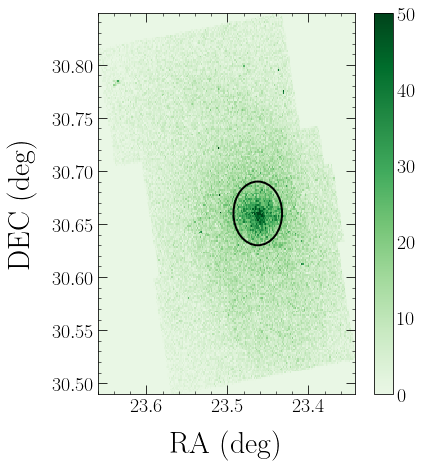

In [12]:
fig, ax = plt.subplots(1)

plt.rcParams["axes.axisbelow"] = False

cmap = cm.get_sub_cmap('Greens', 0.1, 1.0)

qc, = np.where(phatter.F160W_VEGA.evaluate(selection='IR_GST') <= 20)
plot = ax.hist2d(ra_gst[qc], dec_gst[qc],
                 bins=200,
                 cmap=cmap,
                 vmax=50
                 
                
                );
ctr = patches.Circle((23.4625, 30.66), radius=0.03, edgecolor='black', facecolor=(0,0,0,0), linewidth=2)
ax.add_patch(ctr)

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_aspect(m33_ar)
ax.invert_xaxis()

cbar = plt.colorbar(plot[3]);
cbar.ax.tick_params(which='both', length=0);

plt.savefig('./images/ctr_cutout.png', bbox_inches='tight')

In [13]:
distance = np.sqrt( ((unwise['ra'] - 23.4625)*np.cos(30.66 * np.pi / 180))**2 + 
               (unwise['dec'] - 30.66)**2)
outside, = np.where(distance >= 0.03)
unwise = unwise[outside]

#Add an index to more easily reference specific sources
unwise['index'] = np.arange(0, len(unwise), 1)

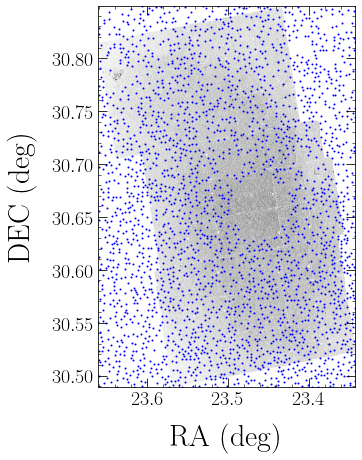

In [14]:
#sanity check

fig, ax = plt.subplots(1)

ax.hist2d(ra_gst, dec_gst,
                 bins=300,
                 cmap='Greys',
                 vmax=500,
                
                );

ax.scatter(unwise['ra'], unwise['dec'],
                  s=1,
                  c='blue'
                );
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_aspect(m33_ar)
ax.invert_xaxis()

In [15]:
#Converts flux measurements to vega magnitude, valid for W1 and W2
#Conversion from 'The unWISE Catalog: Two Billion Infrared Sources from Five Years of WISE Imaging'
#DOI 10.3847/1538-4365/aafbea

def unwise_to_mag(flux):
  mag = 22.5 - 2.5 * np.log10(flux)
  return mag

In [16]:
#For sources with W2 flux measurements, convert flux to W2 magnitude

w2_mags = []

for source in unwise['flux_2']:
    if source != 0.0:
        mag = unwise_to_mag(source)
    else:
        mag = -9999.999
    
    w2_mags.append(mag)

In [17]:
#Add columns to data with W1 and W2 (where available) magnitudes

unwise['w1_mag'] = unwise_to_mag(unwise['flux_1'])
#unwise['w2_mag'] = w2_mags

## Check Very Bright WISE Stars

In [18]:
ex_mw, = np.where(unwise['flux_1'] < 10000)

In [19]:
#WISE sources W1 flux median, mean, std, & maximm
np.median(unwise['flux_1']).round(), np.mean(unwise['flux_1']).round(), np.std(unwise['flux_1']).round(), np.max(unwise['flux_1'])

(680.0, 1480.0, 5383.0, 184030.0)

In [20]:
mw, = np.where(unwise['flux_1'] >= 10000)

In [21]:
unwise_to_mag(10000)

12.5

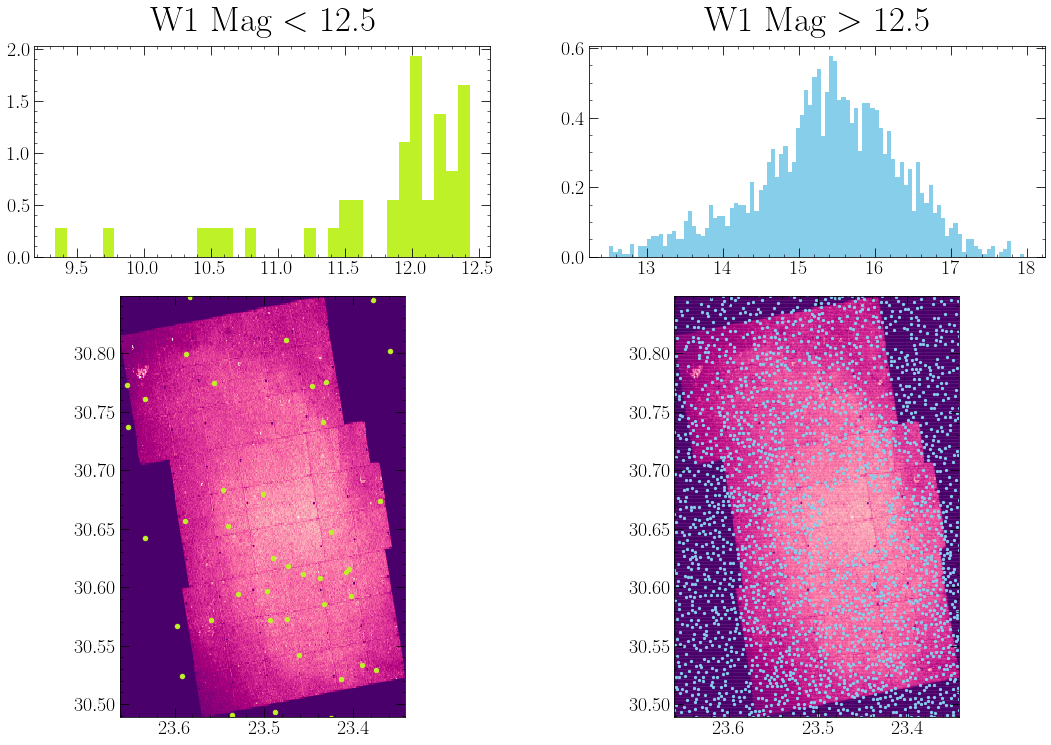

In [22]:
fig, ax = plt.subplots(2,2, gridspec_kw={'width_ratios': [1,1], 'height_ratios': [1,2]})
fig.set_size_inches(15,10)
fig.tight_layout(w_pad=5)

ax[0,0].hist(unwise['w1_mag'][mw], 
             bins=35, density=True,
             color='xkcd:yellowy green')
ax[0,0].set_title('W1 Mag $<$ 12.5')
ax[0,1].hist(unwise['w1_mag'][ex_mw], 
             bins=100, density=True,
             color='skyblue');
ax[0,1].set_title('W1 Mag $>$ 12.5')

ax[1,0].set_aspect(m33_ar)
ax[1,0].hist2d(ra_gst,dec_gst, bins=300)
ax[1,0].scatter(unwise['ra'][mw], unwise['dec'][mw], s=20, c='xkcd:yellowy green')
ax[1,0].invert_xaxis()

ax[1,1].set_aspect(m33_ar)
ax[1,1].hist2d(ra_gst,dec_gst, bins=300, alpha=0.7)
ax[1,1].scatter(unwise['ra'][ex_mw], unwise['dec'][ex_mw], s=5, color='skyblue');
ax[1,1].invert_xaxis();

In [23]:
unwise['w2_mag'] = unwise_to_mag(unwise['flux_2'])

<ipython-input-15-769e318a72f3>:6: RuntimeWarning: divide by zero encountered in log10
  mag = 22.5 - 2.5 * np.log10(flux)


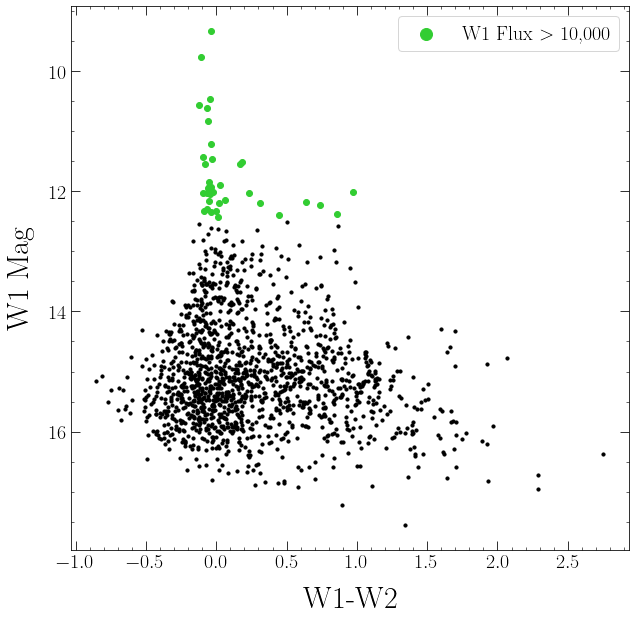

In [24]:
###Look at where these stars lie on a CMD

fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)

ax.scatter(unwise['w1_mag'] - unwise['w2_mag'], unwise['w1_mag'], s=10, c='black')
ax.scatter(unwise['w1_mag'][mw] - unwise['w2_mag'][mw], unwise['w1_mag'][mw], c='limegreen', label='W1 Flux $>$ 10,000')
ax.invert_yaxis()
ax.set_xlabel('W1-W2')
ax.set_ylabel('W1 Mag')
ax.legend();

# Color Conversion

In [25]:
# Read in the ALLWISE catalog
allwise = pd.read_csv('./allwise_p3as_psd_bright.stars.tbl',
                   delim_whitespace=True,
                   skiprows=range(0,44),
                   names=['id','ra','dec','w1','w1sig','w2','w2sig','w3','w3sig','w4','w4sig','j','h'])

In [26]:
allwise[:3]

,id,ra,dec,w1,w1sig,w2,w2sig,w3,w3sig,w4,w4sig,j,h
0,J133518.79-635055.7,203.828333,-63.848831,8.984,0.023,9.064,0.021,9.159,0.055,8.636,NaN,10.376,9.524
1,J133623.57-632255.0,204.098246,-63.381949,9.454,0.023,9.595,0.021,9.276,0.099,8.031,0.391,11.283,10.165
2,J133740.28-631043.0,204.417851,-63.178638,8.367,0.023,8.474,0.021,8.173,0.045,8.238,0.483,10.836,9.308


Check LMC draw circle around blob, ten degree circle (dont forget cosine) 
look at color mag and colcol for things there (since they have to be red giants)

In [27]:
lmc_dist = np.sqrt(((((allwise['ra'] - 79)*np.cos(allwise['dec']*np.pi/180))**2)/(4)) + (((allwise['dec'] +69)**2)/(4)))
lmc, = np.where(lmc_dist < 1)

INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


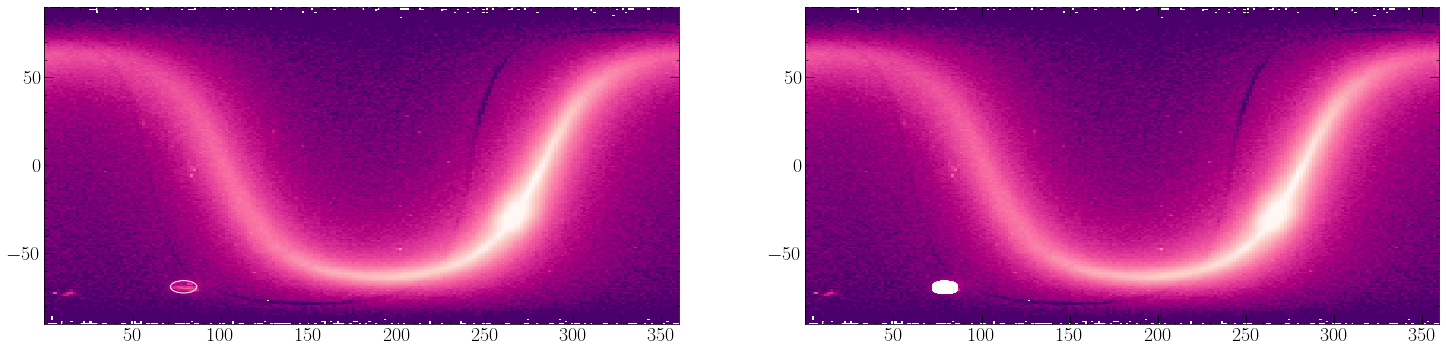

In [28]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(25,15)

ax[0].set_aspect(1)
dmap = ax[0].hist2d(allwise['ra'],allwise['dec'],
                  bins=200,
                  norm=mpl.colors.LogNorm(vmin=10,vmax=1e4),
                 cmap='RdPu_r');

lmc_ptch = patches.Ellipse((79, -69), width=15, height=7, edgecolor='white', facecolor='none')
ax[0].add_patch(lmc_ptch)


ax[1].set_aspect(1)
dmap = ax[1].hist2d(allwise['ra'],allwise['dec'],
                  bins=200,
                  norm=mpl.colors.LogNorm(vmin=10,vmax=1e4),
                 cmap='RdPu_r');
ax[1].scatter(allwise['ra'][lmc], allwise['dec'][lmc], c='white');

In [29]:
nonan, = np.where((np.isnan(allwise['w1']) == False) & 
                   (np.isnan(allwise['w2']) == False) & 
                    (np.isnan(allwise['w3']) == False) & 
                     (np.isnan(allwise['w4']) == False) &
                  (np.isnan(allwise['j']) == False) &
                  (np.isnan(allwise['h']) == False)
                  
                 )

In [30]:
w1 = np.array(allwise['w1'][nonan])
w2 = np.array(allwise['w2'][nonan])
w3 = np.array(allwise['w3'][nonan])
w4 = np.array(allwise['w4'][nonan])
j = np.array(allwise['j'][nonan])
h = np.array(allwise['h'][nonan])

In [31]:
w1lmc = np.array(allwise['w1'][lmc])
w2lmc = np.array(allwise['w2'][lmc])
w3lmc = np.array(allwise['w3'][lmc])
w4lmc = np.array(allwise['w4'][lmc])
jlmc = np.array(allwise['j'][lmc])
hlmc = np.array(allwise['h'][lmc])

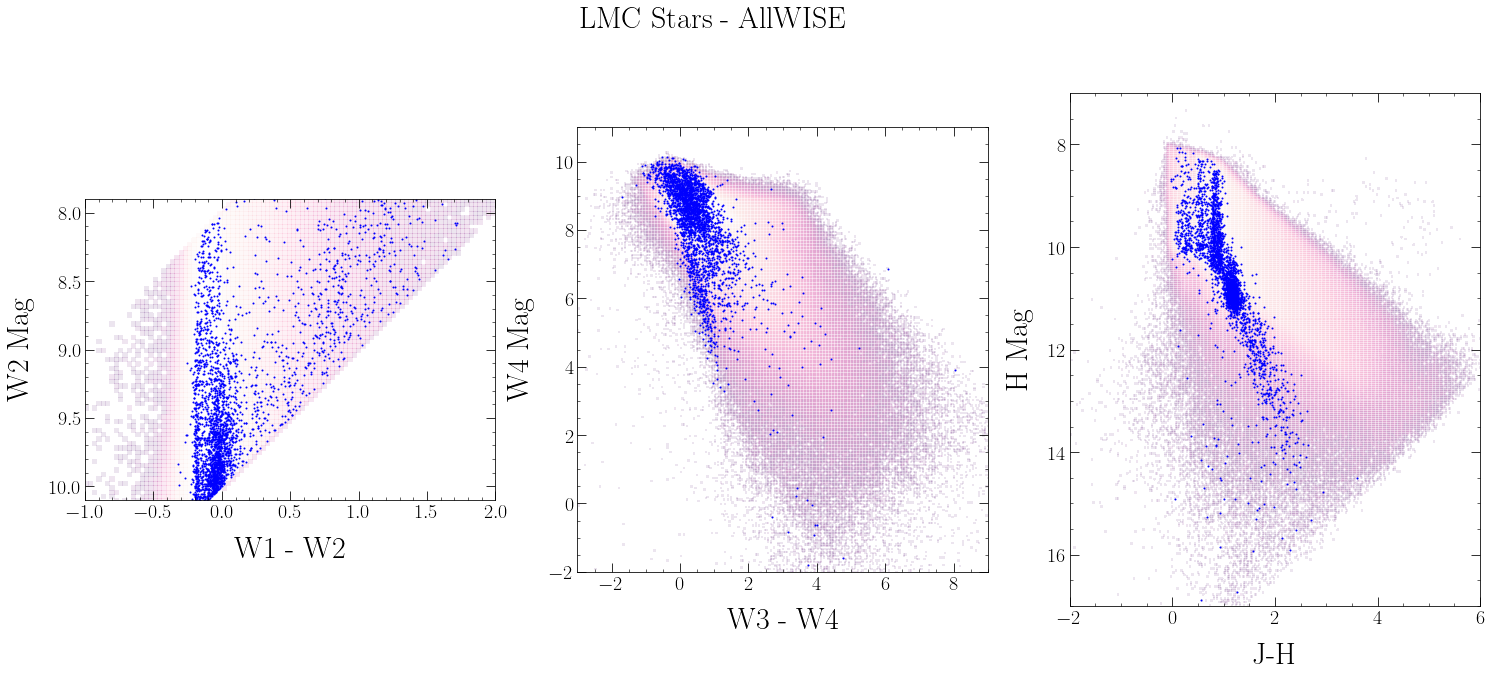

In [107]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(25,10)

w1w2 = ax[0].hist2d(w1- w2, w2, bins=400, norm=mpl.colors.LogNorm(vmin=1, vmax=1e4), alpha=0.1);
w1w2lmc = ax[0].scatter(w1lmc - w2lmc, w2lmc, s=1, c='blue')
ax[0].set_aspect(1)
ax[0].set_ylim(7.9,10.1)
ax[0].set_xlim(-1,2)
ax[0].invert_yaxis()
ax[0].set_xlabel('W1 - W2')
ax[0].set_ylabel('W2 Mag')


w3w4 = ax[1].hist2d(w3 - w4, w4, bins=400, norm=mpl.colors.LogNorm(vmin=1, vmax=1e4), alpha=0.1)
w3w4lmc = ax[1].scatter(w3lmc - w4lmc, w4lmc, s=1, c='blue')
ax[1].set_aspect(1)
ax[1].set_ylim(11,-2)
ax[1].set_xlim(-3,9)
ax[1].invert_yaxis()
ax[1].set_xlabel('W3 - W4')
ax[1].set_ylabel('W4 Mag')

jh = ax[2].hist2d(j-h, h, bins=400, norm=mpl.colors.LogNorm(vmin=1, vmax=1e4), alpha=0.1)
jhlmc = ax[2].scatter(jlmc - hlmc, hlmc, s=1, c='blue')
ax[2].set_aspect(1)
ax[2].set_ylim(7,17)
ax[2].set_xlim(-2,6)
ax[2].invert_yaxis()
ax[2].set_xlabel('J-H')
ax[2].set_ylabel('H Mag')

fig.text(0.4, 0.95, 'LMC Stars - AllWISE', fontsize=30);

In [240]:
colors = ['r', 'orange', 'y', 'g', 'b', 'violet', 'hotpink', 'darkorange', 'limegreen', 'cyan'] * 20

In [326]:
windows = [hw1_lmc[np.where((jh_lmc >= lmc_colcol[1][i]) 
                            & (jh_lmc < lmc_colcol[1][i+1]))] 
           for i in range(len(lmc_colcol[1]) -1)]

In [377]:
running_mean = []
nz = []
for i in range(200):
    window = hw1_lmc[np.where((jh_lmc >= lmc_colcol[1][i]) 
                            & (jh_lmc < lmc_colcol[1][i+1]))]
    if window.size > 2:
        iqr = np.percentile(window, [25,75])
        keep = np.where((window >= iqr[0]) & (window <= iqr[1]))
        mean = np.mean(window[keep])
        running_mean.append(mean)
        nz.append(i)
    
#    elif window.size ==2 or window.size ==1:
#        mean = np.mean(window)
#        running_mean.append(mean)
#        nz.append(i)
    else:
        pass

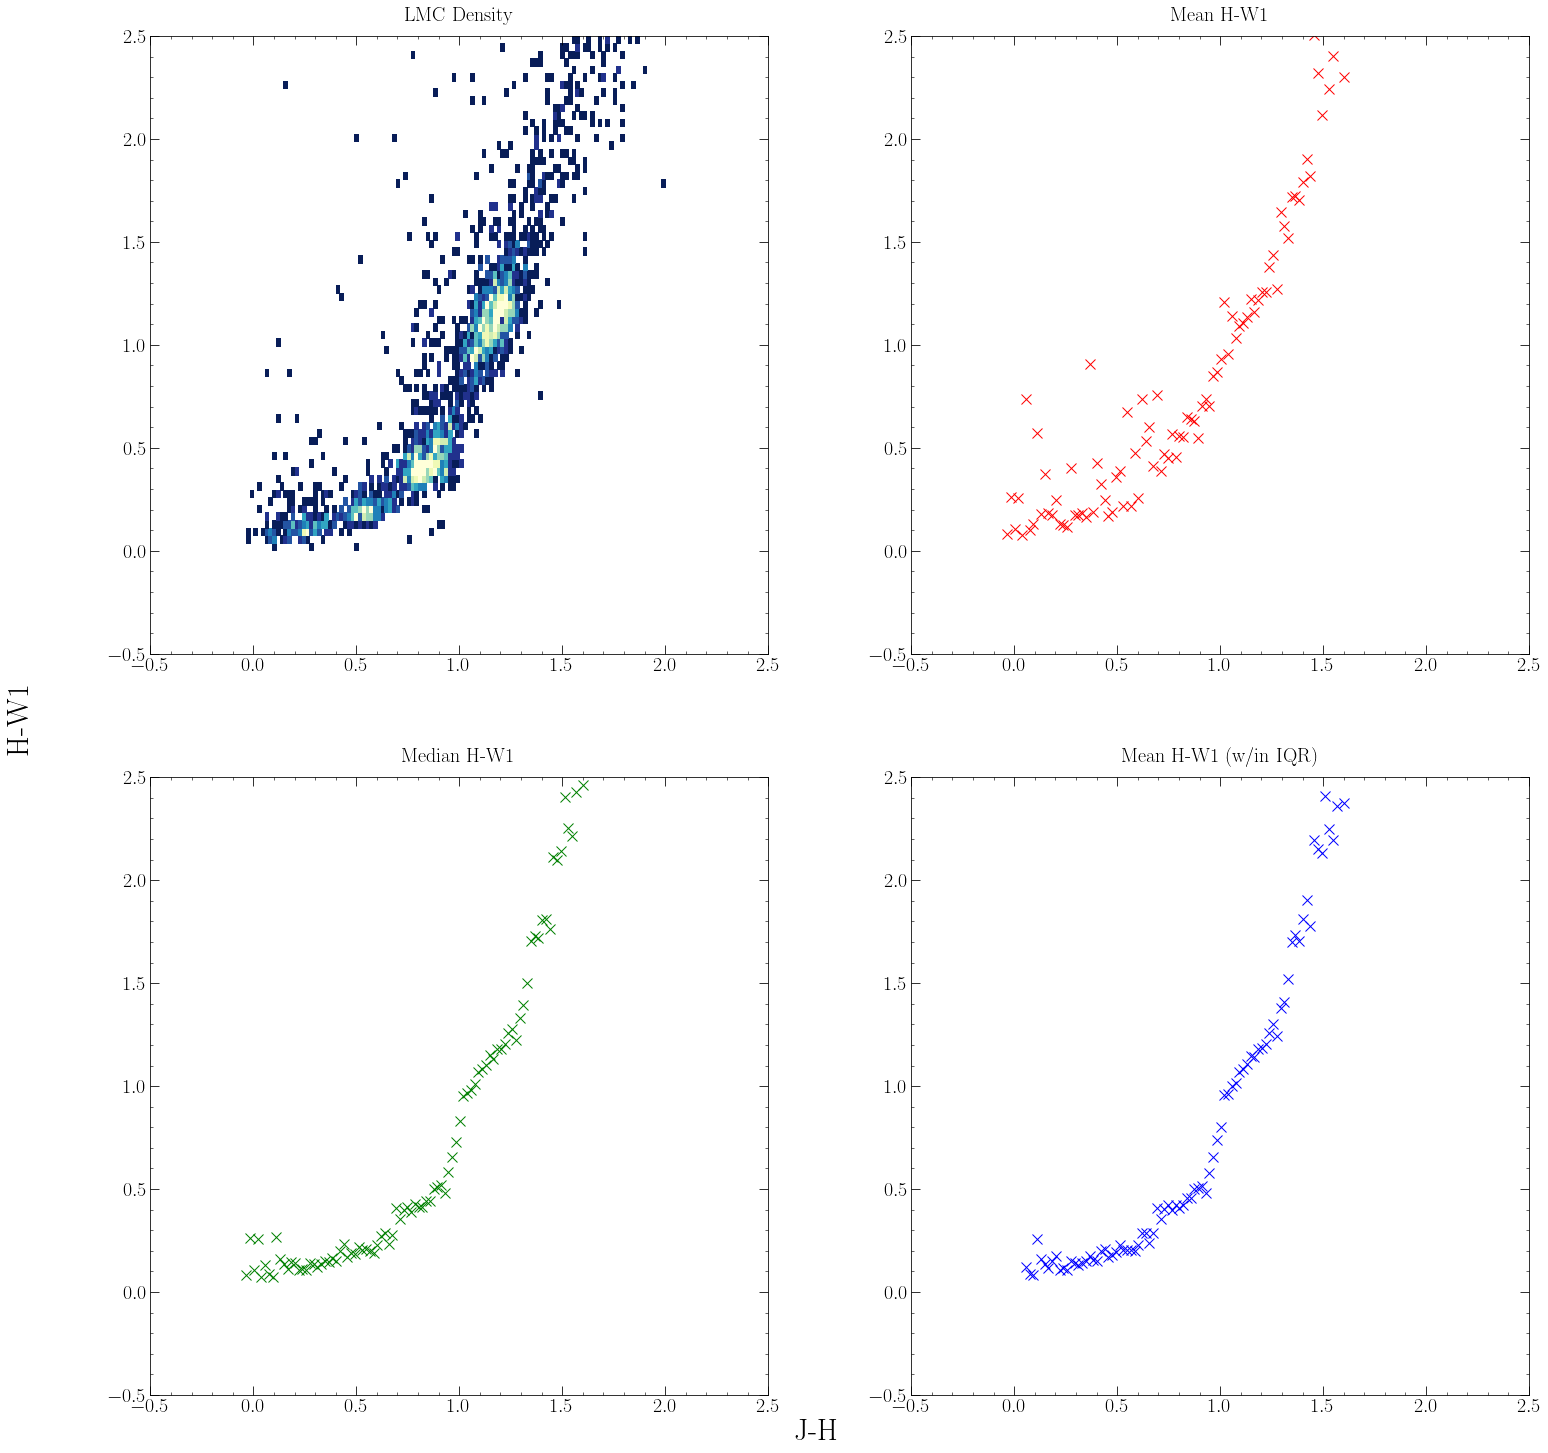

In [378]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(25,25)

gg, = np.where(np.isnan(np.array(allwise['j'][lmc])) == False)

#colcol = ax[2].hist2d(j-h, h-w1,  bins=400, cmap='Greys', norm=mpl.colors.LogNorm(vmin=1, vmax=1e5), alpha=1);
lmc_colcol = ax[0,0].hist2d(jlmc[gg]-hlmc[gg], hlmc[gg] -w1lmc[gg], 
                    cmap='YlGnBu_r', vmin=1, vmax=10,
                    bins=200, cmin=1)

ax[0,0].set_aspect(1)
ax[0,0].set_title('LMC Density', fontsize=20)
ax[0,0].set_xlim(-0.5, 2.5)
ax[0,0].set_ylim(-0.5, 2.5);

mean_cols = [np.mean(hw1_lmc[np.where((jh_lmc >= lmc_colcol[1][i]) & (jh_lmc < lmc_colcol[1][i+1]))]) for i in range(len(lmc_colcol[1]) -1)]
std_cols = [np.std(hw1_lmc[np.where((jh_lmc >= lmc_colcol[1][i]) & (jh_lmc < lmc_colcol[1][i+1]))]) for i in range(len(lmc_colcol[1]) -1)]
ax[0,1].set_aspect(1)
ax[0,1].scatter(lmc_colcol[1][:-1], mean_cols, s=100, c='r', marker='x', linewidth=1)
#ax[0,1].scatter(lmc_colcol[1][:-1], std_cols, s=30, c='b', marker='_', linewidth=1)
ax[0,1].set_xlim(-0.5, 2.5)
ax[0,1].set_ylim(-0.5, 2.5);
ax[0,1].set_title('Mean H-W1', fontsize=20)

med_cols = [np.median(hw1_lmc[np.where((jh_lmc >= lmc_colcol[1][i]) & (jh_lmc < lmc_colcol[1][i+1]))]) for i in range(len(lmc_colcol[1]) -1)]
ax[1,0].set_aspect(1)
ax[1,0].scatter(lmc_colcol[1][:-1], med_cols, s=100, c='g', marker='x', linewidth=1)
ax[1,0].set_xlim(-0.5, 2.5)
ax[1,0].set_ylim(-0.5, 2.5);
ax[1,0].set_title('Median H-W1', fontsize=20)

ax[1,1].scatter(lmc_colcol[1][:-1][nz], running_mean, s=100, c='b', marker='x', linewidth=1)
ax[1,1].set_aspect(1)
ax[1,1].set_xlim(-0.5, 2.5)
ax[1,1].set_ylim(-0.5, 2.5);
ax[1,1].set_title('Mean H-W1 (w/in IQR)', fontsize=20)

#plt.colorbar(lmc_colcol[3], ax=ax, fraction=0.01375);
fig.text(0.05, 0.5, 'H-W1', rotation='vertical', verticalalignment='center', fontsize=30);
fig.text(0.5, 0.1, 'J-H', horizontalalignment='center', fontsize=30);

In [419]:
xs = lmc_colcol[1][:-1][nz]
sqr_spline = spline(xs, running_mean, k=2)
cube_spline = spline(xs, running_mean, k=3)
unsmooth = spline(xs, running_mean, s=1)

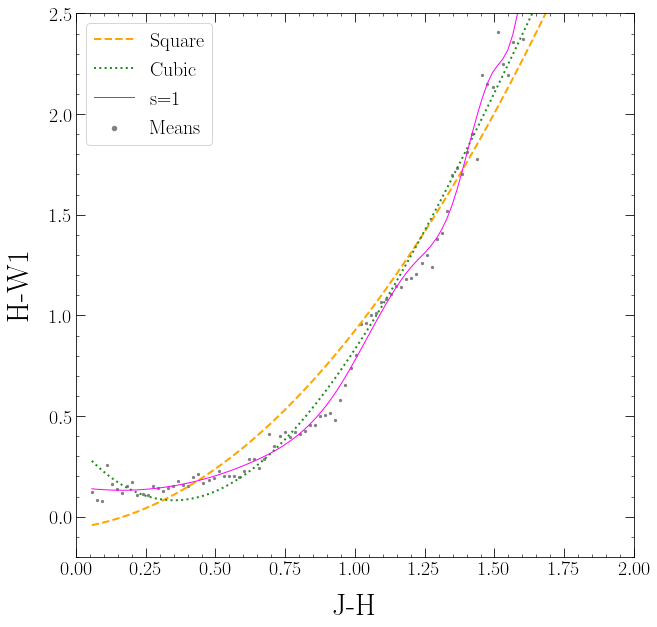

In [436]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)

ax.set_xlim(0.0, 2.0)
ax.set_ylim(-0.2, 2.5)
ax.set_xlabel('J-H')
ax.set_ylabel('H-W1')
ax.plot(xs, sqr_spline(xs), linewidth=2, linestyle='--', label='Square', c='orange')
ax.plot(xs, cube_spline(xs), linewidth=2, linestyle=':', label='Cubic', c='forestgreen')
ax.plot(xs, unsmooth(xs), linewidth=1, label='s=1', c='fuchsia')
ax.scatter(xs, running_mean, c='grey', s=5, label='Means');
ax.legend(loc='best');

In [416]:
splines = [spline(xs, running_mean, s=i+1) for i in range(3)]

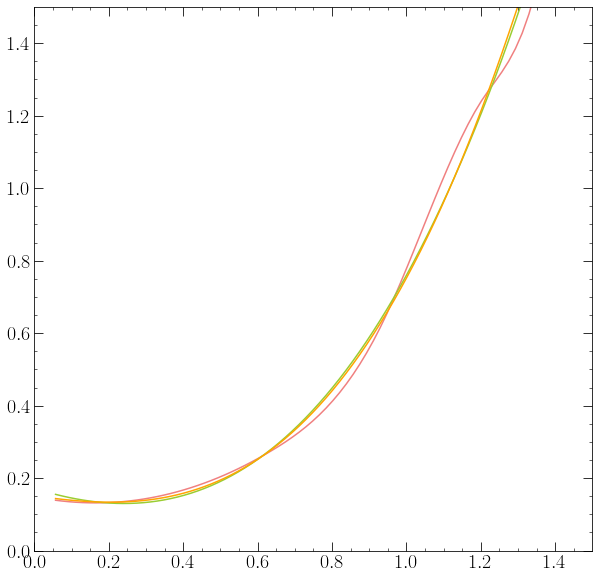

In [418]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)

ax.set_xlim(0.0, 1.5)
ax.set_ylim(0.0, 1.5)

plots = [ax.plot(xs, splines[i](xs)) for i in range(3)]

In [34]:
#Cut out all sources with no W1, J, or H 
#and exclude the most dense regions of the histogram
#to mitigate the effects of crowding and dust on the color locus

ind = ri.get_indices(dmap,allwise['ra'],allwise['dec'])
gd, = np.where( ~np.isnan(allwise['w1']) &
                ~np.isnan(allwise['j']) & ~np.isnan(allwise['h']) &
                (dmap[0].ravel()[ind]>=30) & (dmap[0].ravel()[ind]<300) )

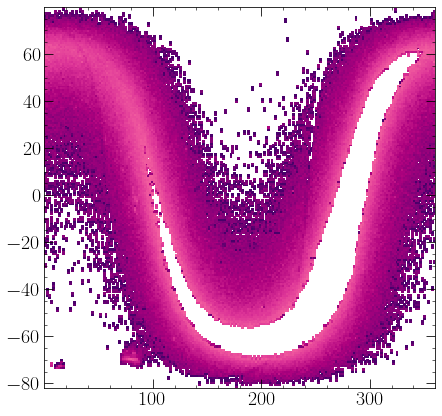

In [35]:
dmap2 = plt.hist2d(allwise['ra'][gd],allwise['dec'][gd],
                   bins=200,
                   norm=mpl.colors.LogNorm(vmin=10,vmax=1e4))

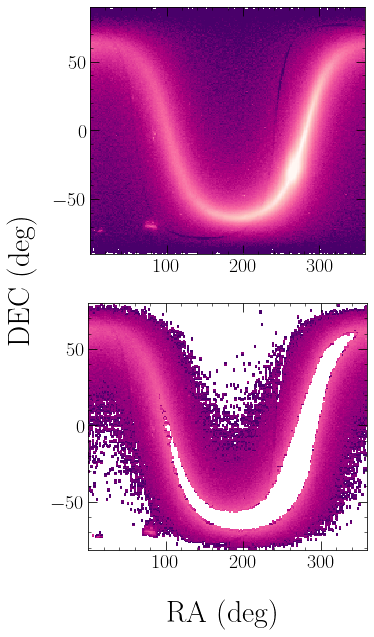

In [36]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(5,10)

ax[0].set_aspect(1.8)
dmap = ax[0].hist2d(allwise['ra'],allwise['dec'],
                  bins=200,
                  norm=mpl.colors.LogNorm(vmin=10,vmax=1e4),
                 cmap='RdPu_r')

#ax[1].set_aspect(2)
dmap2 = ax[1].hist2d(allwise['ra'][gd],allwise['dec'][gd],
                   bins=200,
                   norm=mpl.colors.LogNorm(vmin=10,vmax=1e4))

fig.text(0.5, 0.025, 'RA (deg)', horizontalalignment='center', fontsize=30);
fig.text(-0.1, 0.5, 'DEC (deg)', verticalalignment='center', rotation='vertical', fontsize=30);

plt.savefig('./images/mw_density.png', bbox_inches='tight')

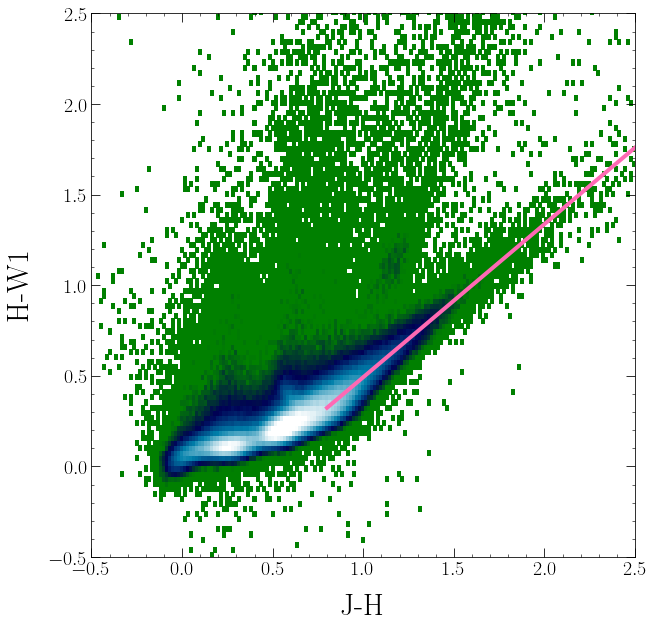

In [37]:
jhcol = np.asarray(allwise['j'][gd]-allwise['h'][gd])
hw1col = np.asarray(allwise['h'][gd]-allwise['w1'][gd])

fig,ax = plt.subplots()
fig.set_size_inches(10,10)

jhbins,hw1bins = np.arange(-0.5,2.5,0.02),np.arange(-0.5,2.5,0.02)
colcol = ax.hist2d(jhcol,hw1col,
                   bins=[600,600],
                   norm=mpl.colors.LogNorm(vmin=10,vmax=1e4),
                   cmap='ocean'
                  )

ax.set_aspect(1)
ax.set_xlabel('J-H')
ax.set_ylabel('H-W1')
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.5,2.5)

ind = ri.get_indices(colcol,jhcol,hw1col)
wh, = np.where( (colcol[0].ravel()[ind]>=50) & (jhcol>1) )

def line(x,m,b):
    return m*x+b
p,cov = curve_fit(line,jhcol[wh],hw1col[wh])

x = np.linspace(0.8,2.5,1000)
ax.plot(x,line(x,*p),'hotpink', linewidth=4);

In [38]:
col_data = np.array([jhcol, hw1col])
col_kde = gaussian_kde(col_data)
X,Y = np.meshgrid(np.linspace(-0.5,2.5,100), np.linspace(-0.5,2.5,100))
points = np.vstack([X.ravel(), Y.ravel()])

In [39]:
%time
z = col_kde(points)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [40]:
test = line(x, *p)

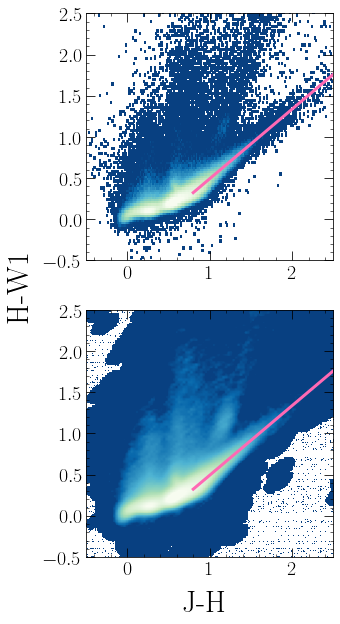

In [41]:
Z = np.reshape(z, X.shape)

fig, ax = plt.subplots(2,1)
fig.set_size_inches(5,10)

ax[0].set_aspect(1)
ax[0].hist2d(jhcol,hw1col,bins=[600,600],
             norm=mpl.colors.LogNorm(vmin=10,vmax=1e4),
             cmap='GnBu_r'
            )

ax[0].set_xlim(-0.5,2.5)
ax[0].set_ylim(-0.5,2.5)

ax[1].set_aspect(1)
ax[1].imshow(np.flipud(Z), 
             norm=mpl.colors.LogNorm(vmin=0.001,vmax=10),
             cmap='GnBu_r',
             extent=[-0.5,2.5,-0.5,2.5]
            )

ax[0].plot(x,line(x,*p),'hotpink', linewidth=3);
ax[1].plot(x,line(x,*p),'hotpink', linewidth=3);

fig.text(0.5, 0.05, 'J-H', fontsize=30, horizontalalignment='center')
fig.text(-0.05, 0.5, 'H-W1', fontsize=30, verticalalignment='center', rotation='vertical');

plt.savefig('./images/color_locus.png', bbox_inches='tight')

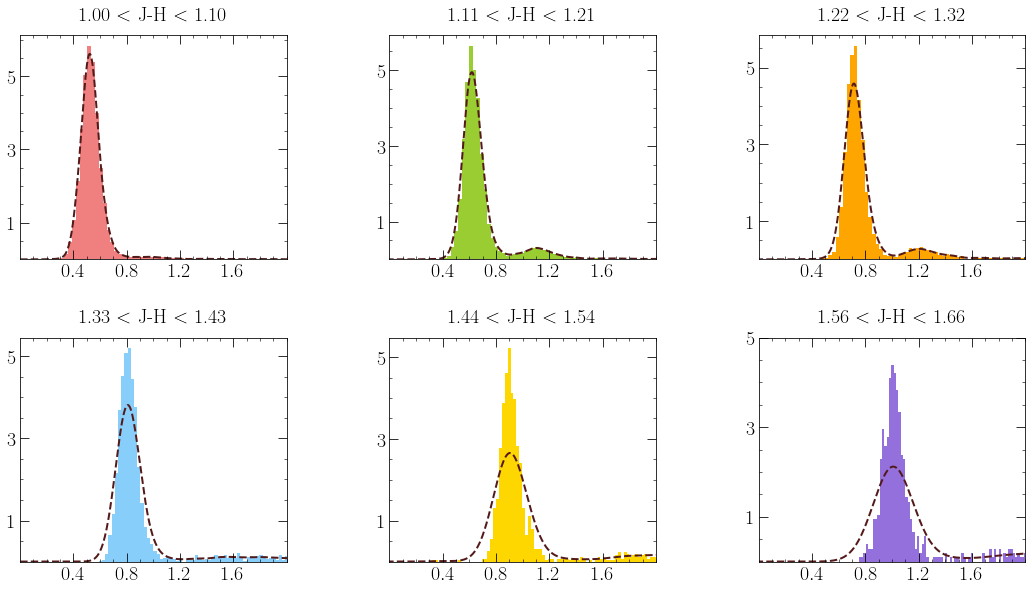

In [42]:
fig, axx = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.tight_layout(h_pad=5, w_pad=5)

#plt.margins(x=0, y=0)
xticks = [0.4, 0.8, 1.2, 1.6]
yticks= [1, 3, 5]

jhs = np.linspace(1.0, 2.0, 10)
x = np.linspace(-0.5,2.5,1000)
cols = ['lightcoral', 'yellowgreen', 'orange', 'lightskyblue', 'gold', 'mediumpurple']

for i,ax in enumerate(axx.ravel()):
    sample, = np.where((jhcol >= jhs[i]) & (jhcol < jhs[i] + 0.1) & (hw1col <= 2.5))
    hw1s = hw1col[sample]
    kde = gaussian_kde(hw1col[sample])
    kde_pdf = kde.evaluate(x)
    
    ax.plot(x, kde_pdf, linestyle='--', linewidth=2, color='#541A1A')
    ax.hist(hw1s, bins=100, density=True, color=cols[i])
    ax.set_xlim(0.0, 2.0)
    ax.set_title('{:.2f} $<$ J-H $<$ {:.2f}'.format(jhs[i], jhs[i] + 0.1), fontsize=20)

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
plt.savefig('./images/color_spread.png', bbox_inches='tight');

In [43]:
###F160W to H conversion (using color conversions from https://arxiv.org/pdf/1109.6893.pdf (Dalcanton, 2018))
def convert_to_JH(f110w,f160w):
    j_h = 0.9418 + 0.841*(f110w-f160w-1.0) - 0.9053*(f110w-f160w-1.0)**2
    return j_h
def HST_to_2MASS(f110w,f160w):
    f160w_h = 0.2031 + 0.401*(convert_to_JH(f110w,f160w) - 0.9) + 0.3498*(convert_to_JH(f110w,f160w) - 0.9)**2
    h = f160w - f160w_h
    j = h + convert_to_JH(f110w,f160w)
    return j,h

###Define J and H for ph_data sources and add to dataframe

j_mag, h_mag = HST_to_2MASS(phatter['F110W_VEGA'], phatter['F160W_VEGA'])

phatter['J_Mag'], phatter['H_Mag'], phatter['J_H'] = j_mag, h_mag, j_mag - h_mag


###Convert J-H to H-W1 using parameters from fit (see Color_Conversion.ipynb), then get W1 mags for PHATTER sources
m_fit, b_fit = 0.84805331, -0.35556147

phatter['H_W1'] = m_fit*phatter['J_H'] + b_fit

phatter['W1_Mag'] = phatter['H_Mag'] - phatter['H_W1']

###Convert W1 magnitude to flux and add column to data
def m_to_flux(mag):
  result = 10**((mag - 22.5) / (-2.5))
  return result

phatter['W1_Flux'] = m_to_flux(phatter['W1_Mag'])

In [44]:
x1 = np.linspace(-1.0, 1.14, 1000)
x2 = np.linspace(1.16, 2.5, 1000)
y1 = np.repeat(19.48, 1000)
y2 = 2 * x2 + 17.18

In [45]:
xs = np.concatenate((x1,x2), axis=0)
ys = np.concatenate((y1,y2), axis=0)

In [46]:
xg1 = np.linspace(-1.0, 1.2, 1000)
xg2 = np.linspace(1.2, 2.5, 1000)
yg1 = np.repeat(19.28, 1000)
yg2 = 2 * xg2 + 16.88

In [47]:
gxs = np.concatenate((xg1,xg2), axis=0)
gys = np.concatenate((yg1,yg2), axis=0)

In [48]:
#Color cuts to PHATTER sample following criteria from Goldman, et al 2022

phatter.select('(((F160W_VEGA < 19.48) & (F110W_VEGA - F160W_VEGA < 1.15)) | '
               '((F110W_VEGA - F160W_VEGA >= 1.15) & (F160W_VEGA < 2 * (F110W_VEGA - F160W_VEGA) + 17.18))) &'
               'IR_GST', 
               name='COL_CUT')

In [49]:
index_colcut = phatter.INDEX.evaluate(selection='COL_CUT')
RA,DEC = phatter.RA.evaluate(selection='COL_CUT'), phatter.DEC.evaluate(selection='COL_CUT')

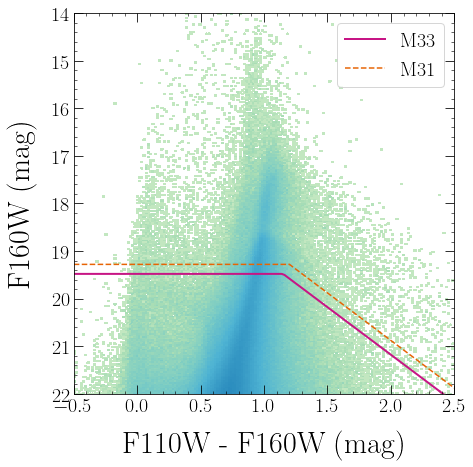

In [50]:
fig, ax = plt.subplots(1)

ax.set_aspect(3/8)


cmd = ax.hist2d(phatter.F110W_F160W.evaluate(selection='IR_GST'), phatter.F160W_VEGA.evaluate(selection='IR_GST'),
          bins=400,
          norm=mpl.colors.LogNorm(vmin=1e-2,vmax=1e5), 
          cmap='GnBu')
ax.plot(xs, ys, c='mediumvioletred', linestyle='-', linewidth=2, 
        label='M33' 
       )

ax.plot(gxs, gys, c='#E76404', linestyle='--', linewidth=1.5, 
        label='M31'
       )

ax.set_xlabel('F110W - F160W (mag)')
ax.set_ylabel('F160W (mag)')
ax.set_ylim(22,14)
ax.set_xlim(-0.5,2.5)

ax.legend(loc='best');

plt.savefig('./images/goldman_cut.png', bbox_inches='tight')

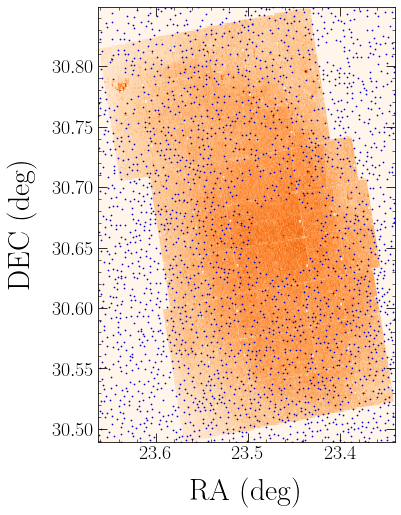

In [51]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,8)

ax.set_aspect(m33_ar)

cmap = plt.cm.get_cmap('Oranges')
hist = ax.hist2d(ra_gst, dec_gst, 
          bins=300,
          cmap=cmap,
          vmin=1, vmax=4e2
                 
         )
ax.scatter(unwise['ra'], unwise['dec'], s=0.5, marker='o', c='mediumblue')
ax.set_xlim(phatter.RA.max(), phatter.RA.min())
ax.set_xticks([23.4, 23.5, 23.6])
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)');

plt.savefig('./images/wise_overlay.png', bbox_inches='tight')

## Average Star Separation

In [52]:
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import SkyCoord
from astropy.table import Table

In [53]:
#Convert RA and DEC to SkyCoords to use astropy separation
sep_coords = SkyCoord(RA, DEC, unit='deg')

In [54]:
#Astropy find nearest neighbor, nth=2 to avoid matching stars to themselves
closest = match_coordinates_sky(sep_coords, sep_coords, nthneighbor=2)

In [55]:
closest

(array([    19,    724,    669, ..., 120049, 120427, 120813]),
 <Angle [6.34329122e-04, 7.80278115e-05, 7.06590794e-05, ...,
         2.51584959e-04, 2.59730264e-04, 5.22345353e-04] deg>,
 <Quantity [1.10711317e-05, 1.36184222e-06, 1.23323358e-06, ...,
            4.39098589e-06, 4.53314827e-06, 9.11664623e-06]>)

In [56]:
dist3d = np.array(closest[2])

In [57]:
sep2d = np.array(closest[1])

TypeError: missing a required argument: 'x'

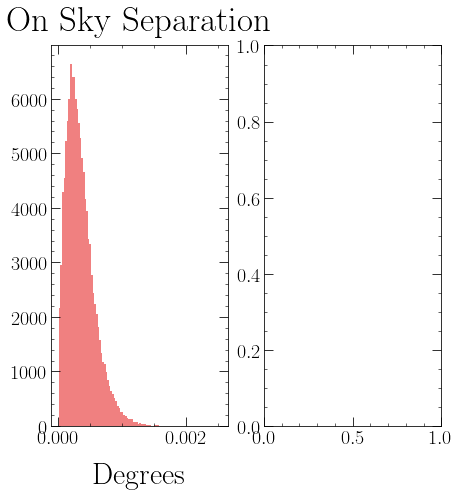

In [58]:
fig, ax = plt.subplots(1,2)
#fig.set_size_inches(25,7)

ctr, = np.where(sep2d <= 0.0006)

ax[0].hist(sep2d, bins=100);
ax[0].set_title('On Sky Separation')
ax[0].set_xlabel('Degrees')

ax[1].scatter()

print(r'Mean (all): {:.2f}"'.format(np.mean(sep2d) * 3600))
print(r'STD (all): {:.2f}"'.format(np.std(sep2d) * 3600))
print(r'Mean (<{:.2f}): {:.2f}"'.format(.0006*3600, np.mean(sep2d[ctr]) * 3600))
print(r'STD (<{:.2f}): {:.2f}"'.format(.0006*3600, np.std(sep2d[ctr]) * 3600))

## Matching Process

In [ ]:
###unWISE RA and DEC
xu, yu = np.array(unwise['ra']), np.array(unwise['dec'])

In [ ]:
ceil((np.max(xu) - np.min(xu)) / (5/3600)), ceil((np.max(yu) - np.min(yu)) / (5/3600))

In [ ]:
ra_bins = np.linspace(np.min(xu), np.max(xu), 232)
dec_bins = np.linspace(np.min(yu), np.max(yu), 261)

In [ ]:
histu,hx,hy = np.histogram2d(xu, yu, bins=[ra_bins, dec_bins])
indu = ri.get_indices(histu, xu, yu, x_bins=hx, y_bins=hy)

In [ ]:
histp,hxx,hyy = np.histogram2d(RA,DEC, bins=[hx,hy])
indp = ri.get_indices(histp, RA,DEC, x_bins=hx, y_bins=hy)

In [ ]:
hist_gst,_,_ = np.histogram2d(ra_gst, dec_gst, bins=[hx,hy])
indgst =  ri.get_indices(hist_gst, ra_gst, dec_gst, x_bins=hx, y_bins=hy)

In [ ]:
indu[200:218]

In [ ]:
uw = 14900
p, = np.where(indp == uw)
uu, = np.where(indu == uw)
uu, p[:5]

In [ ]:
###Check that bin numbers are correctly aligned between the datasets
fig, ax = plt.subplots(1)
fig.set_size_inches(9,9)

bins = 261

ax.set_aspect(1)

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_title('unWISE bin: {}'.format(uw), fontsize=30)

ax.scatter(unwise['ra'][uu], unwise['dec'][uu], 
           edgecolor='black', 
           facecolor='none', 
           marker='o',
           s=200,
           zorder=5,
           linewidths=2
          )
psf = patches.Circle((unwise['ra'][uu], unwise['dec'][uu]), 
                     radius=4.5/3600, 
                     edgecolor='gray', 
                     facecolor=(0,0,0,0),
                     linestyle='--',
                     linewidth=1)
ax.add_patch(psf)

bb = [uw, uw+1, uw-1, uw + bins - 1, uw - bins + 1, uw + bins, uw - bins, uw + bins - 2, uw - bins + 2]
cc = ['yellowgreen', 'pink', 'pink', 'powderblue', 'powderblue', 'orange', 'orange', 'orange', 'orange']

for i,bin in enumerate(bb):
    lox, = np.where(indgst == bb[i])
    ax.scatter(ra_gst[lox], dec_gst[lox],
               color=cc[i], s=5, alpha=0.5)
    
    final, = np.where(indp == bb[i])
    ax.scatter(RA[final], DEC[final],
               color=cc[i], s=100)

    ax.text(np.min(ra_gst[lox]), np.mean(dec_gst[lox]),
                str(bin), fontsize=30)
    

    
plt.savefig('./images/bin_visuals.png', bbox_inches='tight')

In [ ]:
w1f = phatter.W1_Flux.evaluate(selection='COL_CUT')

In [ ]:
col = phatter.F110W_F160W.evaluate(selection='COL_CUT')

In [ ]:
ar_length = len(RA)
flux_fracs = np.full(ar_length, -999.9)
dists = np.full(ar_length, -999.9)
uw_matches = np.full(ar_length, -999)

In [ ]:
match_ids = np.full(len(RA), '****************')

In [ ]:
ph_index = np.arange(0, len(RA), 1)

In [ ]:
%%time
###Number of bins should match the number chosen for reverse indices above
bins = 261

for i,source in enumerate(unwise):
    ###Get bin of unWISE source
    wb = indu[i]
    ###Get indices of PHATTER sources in the same or nearby bins
    loc, = np.where((indp >= wb - bins) & (indp <= wb + bins))
     
    ###Get the distance between each PHATTER source and the unWISE source
    dist = np.sqrt( ((RA[loc] - unwise['ra'][i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 
                   + (DEC[loc] - unwise['dec'][i])**2)
    
    ###Get indices of PHATTER sources where the above distance is 4.5" or less                                                                                                                                              
    matched, = np.where(dist <= 4.5/3600)
    ###Add the objid of the unWISE source 
    ###to the array of match IDs at the index of each matched PHATTER source
    if len(matched) != 0:
        indices = ph_index[loc][matched]
        #ph_ind.append(ind)
        match_ids[indices] = unwise['unwise_objid'][i]
        
        ###Total flux of all matches for WISE source [i], ranking added in case not all matches are used                                                                
        total_flux = np.sum(w1f[indices])#[ranked][::-1])
        ###Fraction of the W1 flux of every HST source over the total flux of all HST matches to WISE source [i]                                                               
        flux_frac = w1f[indices] / total_flux
        ###Adds all matching data to appropriate arrays                                                                                                                                            
        dists[indices] = dist[matched]     
        flux_fracs[indices] = flux_frac
        uw_matches[matched] = i

In [ ]:
match, = np.where(match_ids != '****************')

In [ ]:
df,ff = dists[match] / (4.5/3600), flux_fracs[match]

In [ ]:
ones, = np.where(ff == 1.0)
not_ones, = np.where(ff != 1.0)
len(ones), len(not_ones)

In [ ]:
best_matches, = np.where(ff[not_ones] >= 0.75
                        )
plt.hist(df[not_ones][best_matches], bins=30);
print(np.median(df[not_ones][best_matches]), np.std(df[not_ones][best_matches]))

In [ ]:
c_scale = col[match][not_ones]
bins = [-100, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 100]

fig, axs = plt.subplots(3,3)
fig.tight_layout(w_pad=0, h_pad=0)
fig.set_size_inches(20,20)
plt.grid(visible=True)
cmap = plt.cm.get_cmap('Spectral_r')

ss = np.argsort(c_scale)[::-1]
for i,ax in enumerate(axs.ravel()):
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.grid(True, alpha=1.0, axis='both')
    sec, = np.where((c_scale[ss] >= bins[i]) & (c_scale[ss] < bins[i+1]))
    plot = ax.scatter(df[not_ones][ss][sec], ff[not_ones][ss][sec],
                      marker='o', linewidths=0.2,
                      edgecolor='black',
                      c=c_scale[ss][sec], cmap=cmap,
                      vmin=0.0, vmax=1.5,
                      s=50,
                      zorder=10
                     )

cax = fig.add_axes([1.0, 0.0625, 0.05, 0.90275])
cbar = fig.colorbar(plot, cax=cax, label='F110W-F160W');

fig.text(0.5, 0.0, 'Fractional Distance', fontsize=50, ha='center')
fig.text(0.0, 0.5, 'Fractional Flux', fontsize=50, rotation='vertical', va='center');
    
plt.savefig('./images/flux_vs_dist.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(6,6)
fig.tight_layout(w_pad=5)

ax[0].set_aspect(m33_ar)
ax[1].set_aspect(m33_ar)

ax[0].scatter(RA[match][ones], DEC[match][ones], s=20, c='dodgerblue', zorder=10);
ax[0].hist2d(ra_gst, dec_gst, bins=300, density=True, cmap='Oranges', alpha=0.3);
ax[0].invert_xaxis()

ax[1].scatter(RA[match][not_ones], DEC[match][not_ones], s=0.1, c='darkorchid', zorder=10)
ax[1].hist2d(ra_gst, dec_gst, bins=300, density=True, cmap='Oranges', alpha=0.3);
ctr = patches.Circle((23.4625, 30.66), radius=0.03, edgecolor='black', facecolor=(0,0,0,0), linewidth=2)
ax[1].add_patch(ctr)
ax[1].invert_xaxis()

ax[0].scatter([0], [0], s=20, c='dodgerblue', zorder=10, label='FF = 1')
ax[0].scatter([0], [0], s=20, c='darkorchid', zorder=10, label='FF $<$ 1')
fig.legend(loc='lower center');

In [ ]:
c_scales = [unwise['flux_1'][uw_matches][not_ones],
            unwise['dflux_1'][uw_matches][not_ones],
            unwise['fracflux_1'][uw_matches][not_ones],
            unwise['fluxlbs_1'][uw_matches][not_ones],
            unwise['fwhm_1'][uw_matches][not_ones],
            unwise['rchi2_1'][uw_matches][not_ones],
            phatter.F160W_ERR.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F160W_CROWD.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F160W_CHI.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F110W_ERR.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F110W_CROWD.evaluate(selection='COL_CUT')[match][not_ones],
            phatter.F110W_CHI.evaluate(selection='COL_CUT')[match][not_ones]]

titles = ['W1 Flux', 'dflux\_1', 'fracflux\_1', 
          'fluxlbs\_1', 'fwhm\_1', 'rchi2\_1',
          'F160W\_ERR', 'F160W\_CROWD', 'F160W\_CHI', 
          'F110W\_ERR', 'F110W\_CROWD', 'F110W\_CHI']

orders = [-1,-1,-1,
         -1,1,-1,
         1,1,1,
         1,1,1]

vmxs = [1000, 20, 1.0,
      1000, 2.635, 50,
      0.05, 1., 5,
      0.05, 1., 5]

vmns = [100, 9, 0.75,
       0, 2.618, 5,
       0, 0, 0,
       0, 0, 0]

In [ ]:
fig, axs = plt.subplots(4,3)
fig.tight_layout(h_pad=-0.5, w_pad=-1.5)
fig.set_size_inches(19, 20)

cmap = plt.cm.get_cmap('viridis_r')

for i,ax in enumerate(axs.ravel()):
    ss = np.argsort(c_scales[i])[::orders[i]]
    plot = ax.scatter(df[not_ones][ss], ff[not_ones][ss], 
                      c=c_scales[i][ss], cmap=cmap, 
                      s=5,
                      vmax=vmxs[i],
                      vmin=vmns[i])
    
    ax.set_aspect(1)
    ax.set_title(titles[i], fontsize=20);
    
    plotnum_text = ax.text(0.9, 0.9, str(i+1),
                       fontsize=20, fontweight='bold',
                       bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='darkorange', linewidth=2))

    cbar = fig.colorbar(plot, ax=ax);
    
plt.savefig('./images/ff_df_plots.png', bbox_inches='tight')

In [ ]:
filters = [phatter.F275W_SNR.evaluate(selection='COL_CUT'),
           phatter.F336W_SNR.evaluate(selection='COL_CUT'),
           phatter.F475W_SNR.evaluate(selection='COL_CUT'),
           phatter.F814W_SNR.evaluate(selection='COL_CUT'),
           phatter.F110W_SNR.evaluate(selection='COL_CUT'),
           phatter.F160W_SNR.evaluate(selection='COL_CUT')]

mags = [phatter.F275W_VEGA.evaluate(selection='COL_CUT'),
           phatter.F336W_VEGA.evaluate(selection='COL_CUT'),
           phatter.F475W_VEGA.evaluate(selection='COL_CUT'),
           phatter.F814W_VEGA.evaluate(selection='COL_CUT'),
           phatter.F110W_VEGA.evaluate(selection='COL_CUT'),
           phatter.F160W_VEGA.evaluate(selection='COL_CUT')]

In [ ]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(20,10)
fig.tight_layout(w_pad=5, h_pad=5)

bands = ['F275W\_SNR', 'F336W\_SNR', 'F475W\_SNR', 'F814W\_SNR', 'F110W\_SNR', 'F160W\_SNR']



for i,ax in enumerate(axs.ravel()):
    not_nan, = np.where(np.isnan(mags[i]) == False)
    h = ax.hist(filters[i][not_nan], bins=50, density=True, color=cycle_colors[i])
    ax.set_title(bands[i])
    
    mean = np.mean(filters[i][not_nan])
    std = np.std(filters[i][not_nan])
    max = np.max(filters[i][not_nan])
    
    xmax = mean + 4*std
    ax.set_xlim(0, xmax)
    ax.text(0.6*xmax, 0.7*h[0].max(), 
            'mean: {:.2f} \n std: {:.2f} \n max: {:.2f}'.format(mean, std, max), 
            fontsize=25)

In [ ]:
fig, ax = plt.subplots(1)

ax.scatter(2.5 / (phatter.F110W_SNR.evaluate(selection='COL_CUT') * np.log(10)), 
           phatter.F110W_ERR.evaluate(selection='COL_CUT'), s=1);
ax.set_xlabel('2.5/[SNR*ln(10)]')
ax.set_ylabel('ERR');

In [ ]:
n = 12
###Get the first n unwise object IDs for sources that have matches
first_n = np.unique(match_ids[match][not_ones])[n:2*n]

In [ ]:
first_n

In [ ]:
fig, axs = plt.subplots(4,3, figsize=(11,15))
fig.tight_layout(h_pad=0, w_pad=-1)


for i,ax in enumerate(axs.ravel()[:n]):
 ob, = np.where(unwise['unwise_objid'] == first_n[i])
 ph, = np.where(match_ids == first_n[i])
    
 match_flux = w1f[ph]
 total_flux = np.sum(w1f[ph])
 wise_flux = unwise['flux_1'][ob]
 colors_match = col[ph]
 cmh = cm.get_sub_cmap('Spectral_r', 0.0, 1.0)
 ordered = np.argsort(match_flux)[::-1]
 max_ff = (match_flux[ordered][0] / total_flux).round(2)
    
 ax.set_aspect(1)   

 ax.errorbar(unwise['ra'][ob], unwise['dec'][ob], 
              xerr=(4.5/3600), yerr=(4.5/3600), 
            color='silver', 
            linewidth=2)
 ax.errorbar(unwise['ra'][ob], unwise['dec'][ob], 
              xerr=(3/3600), yerr=(3/3600), 
            color='dimgrey', 
            linewidth=4)
 ax.scatter(unwise['ra'][ob], unwise['dec'][ob], 
           s=total_flux, 
           edgecolors='black', 
           linewidth=2, 
           facecolors='none', 
           marker='o',  
           label='Total Flux of Matches', 
           zorder=6)
 wplot = ax.scatter(unwise['ra'][ob], unwise['dec'][ob], 
           s=wise_flux,
           c='lightgrey',
           label='WISE Source', 
           zorder=5)
 cplot = ax.scatter(RA[ph], 
                   DEC[ph], 
                     s=match_flux, 
                     edgecolors='black', 
                     c=colors_match, 
                     cmap=cmh, 
                     vmin=0.8, vmax=1.2, 
                     label='HST Matches', 
                     zorder=7) 
 
 x,y = unwise['ra'][int(ob)], unwise['dec'][int(ob)]
 ax.set_xlim(x+0.0015, x-0.0015)
 ax.set_xticks([x-0.001, x, x+0.001])
 ax.set_xticklabels(["{:.3f}".format(x-0.001),"{:.3f}".format(x),"{:.3f}".format(x+0.001)], ha='center')
 ax.set_ylim(y-0.0015, y+0.0017)
 ax.set_yticks([y-0.001, y, y+0.001])
 ax.set_yticklabels(["{:.3f}".format(y-0.001),"{:.3f}".format(y),"{:.3f}".format(y+0.001)], va='center')
 ax.tick_params(axis='x',labelsize=15)
 ax.tick_params(axis='y',labelsize=15, rotation=90)


 maxf_text = ax.text(x+0.00135, y+0.00135, 'Max FF: ' + str(max_ff), 
         fontsize=15, fontweight='bold', 
         color='darkturquoise', 
         bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen', lw=1))
 
 plotnum_text = ax.text(x-0.0012, y+0.00135, str(i+1),
                       fontsize=15, fontweight='bold',
                       bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen'))
# end of loop

hst_cax = fig.add_axes([1.0, 0.03, 0.05, 0.954])
hst_cbar = fig.colorbar(cplot, cax=hst_cax)
hst_cbar.ax.tick_params(which='both', size=0)
hst_cbar.set_label('F110W - F160W')

fig.text(0.5, -0.025, 'RA (deg)', horizontalalignment='center', fontsize=30);
fig.text(-0.05, 0.5, 'DEC (deg)', rotation='vertical', verticalalignment='center', fontsize=30);

plt.savefig('./images/cutout_plots.png', bbox_inches='tight')

## False Matches

In [ ]:
shifts = np.array([-36, -24, -12, 12, 24, 36])
distances_shift = []
flux_fracs_shift = []
ras_shift = []
decs_shift = []
uw_ind = []
cols_shift = []

In [ ]:
for j,shift in enumerate(shifts):
  ra_shift = unwise['ra'] + (shift/3600)
  d = []
  f = []
  ra = []
  dec = []
  uind = []
  color=[]

  for i,source in enumerate(unwise):                
    dd = np.sqrt( ((RA - ra_shift[i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 + 
               (DEC - unwise['dec'][i])**2)
    matched, = np.where(dd <= 4.5/3600)
  
    if len(matched) != 0:
      total_flux = np.sum(w1f[matched])
      fff = w1f / total_flux

      d.append(dd[matched])
      f.append(fff[matched])
      ra.append(RA[matched])
      dec.append(DEC[matched])
      uind.append([i]*len(matched))
      color.append(col[matched])
        

  dds = [x for group in d for x in group]
  ffs = [x for group in f for x in group]
  ras = [x for group in ra for x in group]
  decs = [x for group in dec for x in group]
  inds = [x for group in uind for x in group]
  cols = [x for group in color for x in group]

  distances_shift.append(dds)
  flux_fracs_shift.append(ffs)
  ras_shift.append(ras)
  decs_shift.append(decs)
  uw_ind.append(inds)
  cols_shift.append(cols)

In [ ]:
for j,shift in enumerate(shifts):
  dec_shift = unwise['dec'] + (shift/3600)
  d = []
  f = []
  ra = []
  dec = []
  uind = []
  color = []

  for i,source in enumerate(unwise):                
    dd = np.sqrt( ((RA - unwise['ra'][i])*np.cos(dec_shift[i] * np.pi / 180))**2 + 
               (DEC - dec_shift[i])**2)
    matched, = np.where(dd <= 4.5/3600)
  
    if len(matched) != 0:
      total_flux = np.sum(w1f[matched])
      fff = w1f / total_flux

      d.append(dd[matched])
      f.append(fff[matched])
      ra.append(RA[matched])
      dec.append(DEC[matched])
      uind.append([i]*len(matched))
      color.append(col[matched])
        

  dds = [x for group in d for x in group]
  ffs = [x for group in f for x in group]
  ras = [x for group in ra for x in group]
  decs = [x for group in dec for x in group]
  inds = [x for group in uind for x in group]
  cols = [x for group in color for x in group]

  distances_shift.append(dds)
  flux_fracs_shift.append(ffs)
  ras_shift.append(ras)
  decs_shift.append(decs)
  uw_ind.append(inds)
  cols_shift.append(cols)

In [ ]:
d_shift = np.array([l for group in distances_shift for l in group])
f_shift = np.array([k for group in flux_fracs_shift for k in group])
c_shift = np.array([j for group in cols_shift for j in group])

In [ ]:
false_ra = np.array([x for group in ras_shift for x in group])
false_dec = np.array([x for group in decs_shift for x in group])
false_uind = np.array([x for group in uw_ind for x in group])

In [ ]:
false_not_ones, = np.where(f_shift != 1.0)

In [ ]:
c_scale = col[match][not_ones]
bins = [-100, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 100]

fig, axs = plt.subplots(3,3)
fig.tight_layout(w_pad=0, h_pad=0)
fig.set_size_inches(20,20)
plt.grid(visible=True)
cmap = plt.cm.get_cmap('Spectral_r')

ss = np.argsort(c_scale)[::-1]
for i,ax in enumerate(axs.ravel()):
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.grid(True, alpha=1.0, axis='both')
    sec, = np.where((c_scale[ss] >= bins[i]) & (c_scale[ss] < bins[i+1]))
    plot = ax.scatter(df[not_ones][ss][sec], ff[not_ones][ss][sec],
                      marker='o', linewidths=0.2,
                      edgecolor='black',
                      c=c_scale[ss][sec], cmap=cmap,
                      vmin=0.0, vmax=1.5,
                      s=50,
                      zorder=10
                     )

cax = fig.add_axes([1.0, 0.0625, 0.05, 0.90275])
cbar = fig.colorbar(plot, cax=cax, label='F110W-F160W');

fig.text(0.5, 0.0, 'Fractional Distance', fontsize=50, ha='center')
fig.text(0.0, 0.5, 'Fractional Flux', fontsize=50, rotation='vertical', va='center');

In [ ]:
c_scale = c_shift[false_not_ones]
bins = [-100, 0.2, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 100]

fig, axs = plt.subplots(3,3)
fig.tight_layout(w_pad=0, h_pad=0)
fig.set_size_inches(20,20)
plt.grid(visible=True)
cmap = plt.cm.get_cmap('Spectral_r')

ss = np.argsort(c_scale)[::-1]
for i,ax in enumerate(axs.ravel()):
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.grid(True, alpha=1.0, axis='both')
    sec, = np.where((c_scale[ss] >= bins[i]) & (c_scale[ss] < bins[i+1]))
    plot = ax.scatter(d_shift[false_not_ones][ss][sec] / (4.5/3600), f_shift[false_not_ones][ss][sec],
                      marker='o', linewidths=0.2,
                      edgecolor='black',
                      c=c_scale[ss][sec], cmap=cmap,
                      vmin=0.0, vmax=1.5,
                      s=10,
                      zorder=10
                     )

cax = fig.add_axes([1.0, 0.0625, 0.05, 0.90275])
cbar = fig.colorbar(plot, cax=cax, label='F110W-F160W');

fig.text(0.5, 0.0, 'Fractional Distance', fontsize=50, ha='center')
fig.text(0.0, 0.5, 'Fractional Flux', fontsize=50, rotation='vertical', va='center');
    
plt.savefig('./images/flux_vs_dist.png', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(3,4)
fig.tight_layout()
fig.set_size_inches(15, 10)

fig.text(0.5, 0.0, 'Fractional Distance', fontsize=30, horizontalalignment='center')
fig.text(0.0, 0.5, 'Fractional Flux', fontsize=30, rotation='vertical', verticalalignment='center')

arcs = [-36, -24, -12, 12, 24, 36, -36, -24, -12, 12, 24, 36]

for i,ax in enumerate(axs.ravel()):

  xx = np.array((distances_shift[i])) / (4.5/3600)
  yy = np.array(flux_fracs_shift[i])
  
  no, = np.where(yy != 1.0)
    
  ax.set_aspect(1)
  ax.scatter(xx[no],yy[no], s=1, c=(cycle_colors*2)[i]);
  
  if i < 6:
    ax.set_title('RA ' + str(arcs[i]) + '\"', fontsize=20)
  else:
    ax.set_title('DEC ' + str(arcs[i]) + '\"', fontsize=20)

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,6)

ax[0].set_aspect(m33_ar)
ax[0].set_xlim(23.325, 23.675)
ax[0].set_ylim(30.48, 30.855)
cc = ['darkred', 'red', 'orangered', 'darkorange', 'gold', 'yellow', 
        'green', 'lawngreen', 'blue', 'aqua', 'darkviolet', 'mediumorchid']
for i in range(12):
  ff_false = np.array(flux_fracs_shift[i])
  
  one, = np.where(ff_false  == 1.0)
  ax[0].scatter(np.array(ras_shift[i])[one], np.array(decs_shift[i])[one], c=cc[i], s=3)

ones, = np.where(flux_fracs[match] == 1.0)
ax[1].set_aspect(m33_ar)
ax[1].set_xlim(23.325, 23.675)
ax[1].set_ylim(30.48, 30.855)
ax[1].scatter(RA[match][ones], DEC[match][ones]);

In [ ]:
#n**(-1./(d+4)) (n data pts, d dimensions)
17892**(-1/6)

In [ ]:
157232**(-1/6)

In [ ]:
# Set up KDE for false match data
f_shift = f_shift[np.where(f_shift != 1.0)]
d_shift_frac = d_shift[np.where(f_shift!= 1.0)] / (4.5/3600)
false_data = np.array([d_shift_frac, f_shift])
false_kde = gaussian_kde(false_data, bw_method=0.2)
X,Y = np.meshgrid(np.linspace(0,1,200), np.linspace(0.025,0.2,200))
points = np.vstack([X.ravel(), Y.ravel()])

In [ ]:
r_shift = 1/d_shift_frac**2

In [ ]:
dd_obs, ff_obs = df[not_ones], ff[not_ones]

r_obs = 1 / dists[match][not_ones]**2
obs_wts = [r_obs* ff_obs]
obs_wts

In [ ]:
obs_data = np.array([dd_obs, ff_obs])

obs_kde = gaussian_kde(obs_data)#, bw_method=0.2
                      #)

In [ ]:
false_z = false_kde(points)

In [ ]:
obs_z = obs_kde(points)

In [ ]:
false_Z = np.reshape(false_z, X.shape)
norm_false_Z = false_Z / np.sum(false_Z)
obs_Z = np.reshape(obs_z, X.shape)
norm_obs_Z = obs_Z / np.sum(obs_Z)

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches((13*8/5), 8)
fig.tight_layout(w_pad=10)

cmap_data = cm.get_sub_cmap('Spectral_r', 0.0, 1.0)
ss = np.argsort(col[match][not_ones])#[::-1]
obs = ax[0].scatter(dd_obs[ss], ff_obs[ss], 
                    s=10, 
                    c=col[match][not_ones][ss], cmap=cmap_data,
                    vmin=0.5, vmax=2.0)
ax[0].set_title('Observed Data', fontsize=20);
ax[1].set_aspect(1)

false = ax[1].scatter(d_shift_frac, f_shift, s=1)
ax[1].set_title('Artificial Data', fontsize=20);
ax[1].set_aspect(1)

#plt.colorbar(false_smooth, ax=ax[0], label='Density');
plt.colorbar(obs, ax=ax[0], label='F110W-F160W');
#plt.savefig('./images/???.png', bbox_inches='tight')

In [ ]:
x = np.linspace(0,1,1000)
x = x[1:]

for val in x:
    obs_hist = np.histogram2d(dd_obs, ff_obs, bins=bins)[0]
    obs_hist = obs_hist / np.sum(obs_hist)
    art_hist = np.histogram2d(d_shift_frac, f_shift, bins=bins)[0]
    art_hist = art_hist / np.sum(art_hist)
    sub_hist = obs_hist - val*art_hist
    check = np.sum(sub_hist, axis=1)
    if np.min(check) < 0.0:
        print(val.round(6))
        break
    else:
        pass

In [ ]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(25,10)
x = [d_shift_frac, dd_obs]
y = [f_shift, ff_obs]
titles = ['Artificial', 'Observed', 'Overlay']

for i,ax in enumerate(axs):
    if i < 2:
        ax.scatter(x[i],y[i], s=2, c='steelblue', alpha=0.3)
        ax.set_aspect(1)
        ax.set_title(titles[i])
    else:
        ax.set_aspect(1)
        ax.set_title(titles[i])
        ax.scatter(x[0], y[0], s=1, c='steelblue', alpha=0.25)
        ax.scatter(x[1], y[1], s=1, c='orange')

fig.text(0.08, 0.5, 'Fractional Flux', rotation='vertical', verticalalignment='center', fontsize=25);
fig.text(0.5, 0.15, 'Fractional Distance', horizontalalignment='center', fontsize=25);

In [ ]:
x = 0.5866
bins = 300
barcol = 'limegreen'
cmap = cm.get_sub_cmap('Blues', 0.3, 1.0)
norm = mpl.colors.LogNorm(vmin=1e-5, vmax=1e-3)
obs_hist, xedg, yedg, = np.histogram2d(dd_obs, ff_obs, bins=bins)
obs_hist = obs_hist / np.sum(obs_hist)
art_hist = np.histogram2d(d_shift_frac, f_shift, bins=[xedg, yedg])[0]
art_hist = art_hist / np.sum(art_hist)
sub_hist = obs_hist - x*art_hist

hists = [art_hist, obs_hist, sub_hist]
histx = [d_shift_frac, dd_obs]
histy = [f_shift, ff_obs]

titles = ['Artificial', 'Observed', 'Observed - ' + str(x) + 'xArtificial']
left = [0.0, 0.33, 0.66]

fig = plt.figure(figsize=(20,6))

for i in range(3):
    ax = fig.add_axes([left[i], 0.0, 0.3, 0.8])
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    hist = ax.imshow(np.rot90(hists[i]), extent=[0,1,0,1], cmap=cmap, norm=norm)
    
    hax1 = fig.add_axes([left[i] + 0.03, 0.81, 0.239, 0.16], sharex=ax)
    hax2 = fig.add_axes([left[i] + 0.274, 0.0, 0.05, 0.8], sharey=ax)
    hax1.tick_params(which='both', labelcolor='none')
    hax2.tick_params(which='both', labelcolor='none')
    hax1.set_title(titles[i], fontsize=20)
    
    if (i != 2):
        hax1.hist(histx[i], bins=bins, density=True, color=barcol)
        hax2.hist(histy[i], orientation='horizontal', bins=bins, density=True, color=barcol)
    else:
        bbs = np.linspace(0, 1, bins + 1)[:-1]
        hax1.bar(x=bbs, height=np.sum(hists[i], axis=1), width=0.005, align='edge', color=barcol)
        hax2.barh(y=bbs, width=np.sum(hists[i], axis=0), height=0.005, align='edge', color=barcol)
        cax = fig.add_axes([1.01, 0.0, 0.025, 0.8])
        plt.colorbar(hist, cax=cax);
        
fig.text(-0.025, 0.5, 'Fractional Flux', rotation='vertical', verticalalignment='center', fontsize=25);
fig.text(0.5, -0.15, 'Fractional Distance', horizontalalignment='center', fontsize=25);

In [ ]:
fig = plt.figure(figsize=(20,6))

kde_plots = [norm_false_Z, norm_obs_Z, (norm_obs_Z - x*norm_false_Z)]
dedges = np.histogram(dd_obs, bins=bins, density=True)[1]
fedges = np.histogram(ff_obs, bins=bins, density=True)[1]

dhists = [d_shift_frac, dd_obs, np.sum(sub_hist, axis=1)]
fhists = [f_shift, ff_obs, np.sum(sub_hist, axis=0)]
titles = ['Artificial', 'Observed', 'Observed - ' + str(x) + 'xArtificial']
left = [0.0, 0.33, 0.66]

cmap_kde = cm.get_sub_cmap('viridis', 0.0, 1.0)
norm = mpl.colors.LogNorm(vmin=1e-5, vmax=1e-4)

cmaps = []

for i in range(3):
    ax = fig.add_axes([left[i], 0.0, 0.3, 0.8])
    smooth = ax.imshow(np.flipud(kde_plots[i]),
                      cmap=cmap_kde,
                            extent=[0,1,0,1], norm=norm)
    cmaps.append(smooth)
    
    hax1 = fig.add_axes([left[i] + 0.03, 0.81, 0.239, 0.16], sharex=ax)
    hax2 = fig.add_axes([left[i] + 0.274, 0.0, 0.05, 0.8], sharey=ax)
    hax1.tick_params(which='both', labelcolor='none')
    hax2.tick_params(which='both', labelcolor='none')
    hax1.set_title(titles[i], fontsize=20)
    
    
    
    if (i != 2):
        hax1.hist(dhists[i], bins=bins, density=True, color='limegreen')
        hax2.hist(fhists[i], orientation='horizontal', bins=bins, density=True, color='limegreen')
    else:
        hax1.bar(x=dedges[:-1], height=dhists[i], width=0.01, align='edge', color='limegreen')
        hax2.barh(y=fedges[:-1], width=fhists[i], height=0.01, align='edge', color='limegreen')
        
cax = fig.add_axes([1.01, 0.0, 0.025, 0.8])

plt.colorbar(cmaps[2], cax=cax);

fig.text(-0.025, 0.5, 'Fractional Flux', rotation='vertical', verticalalignment='center', fontsize=25);
fig.text(0.5, -0.15, 'Fractional Distance', horizontalalignment='center', fontsize=25);

plt.savefig('./images/kde_combo.png', bbox_inches='tight')

## Catalog

In [ ]:
###Create table with index of the PHATTER data and the objid of the wise source it matched to

#objid_key = Table([phatter.INDEX.evaluate(), match_ids], names=['phatter_index', 'unwise_objid'])

In [ ]:
#m, = np.where(objid_key['unwise_objid'] != '****************')

In [ ]:
#objid_key[m].write('objid_key.csv')
